In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095449 sha256=c8545e97392d268cf28d130c30c2e07d0f278f2d8bdfbafa97c895163872538a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, SVDpp, accuracy
from surprise.model_selection import KFold, cross_validate, GridSearchCV, train_test_split
from surprise.dataset import DatasetAutoFolds
from tqdm import tqdm
import json
import pickle

In [ ]:
PATH = '/content/drive/MyDrive/Pywork/rec_books'

In [ ]:
df = pd.read_csv(PATH+'/train.csv')
df.head(3)

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books


## 데이터셋 준비

In [ ]:
df[['User-ID','Book-ID','Book-Rating']].to_csv('rating_matrix.csv', index=False, header=False)

In [ ]:
col = 'user item rating'
reader = Reader(line_format=col, sep=',', rating_scale=(0,10))
data = Dataset.load_from_file('rating_matrix.csv', reader=reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## 에폭 결정
- factor 수는 2로 설정

 10%|█         | 1/10 [01:45<15:48, 105.41s/it]

RMSE: 3.5028


 20%|██        | 2/10 [03:34<14:21, 107.70s/it]

RMSE: 3.4563


 30%|███       | 3/10 [05:30<12:59, 111.37s/it]

RMSE: 3.4346


 40%|████      | 4/10 [07:32<11:32, 115.42s/it]

RMSE: 3.4249


 50%|█████     | 5/10 [09:36<09:53, 118.61s/it]

RMSE: 3.4202


 60%|██████    | 6/10 [11:43<08:06, 121.64s/it]

RMSE: 3.4219


 70%|███████   | 7/10 [13:57<06:16, 125.51s/it]

RMSE: 3.4282


 80%|████████  | 8/10 [16:19<04:21, 130.66s/it]

RMSE: 3.4373


 90%|█████████ | 9/10 [18:41<02:14, 134.23s/it]

RMSE: 3.4476


100%|██████████| 10/10 [21:09<00:00, 126.99s/it]

RMSE: 3.4583


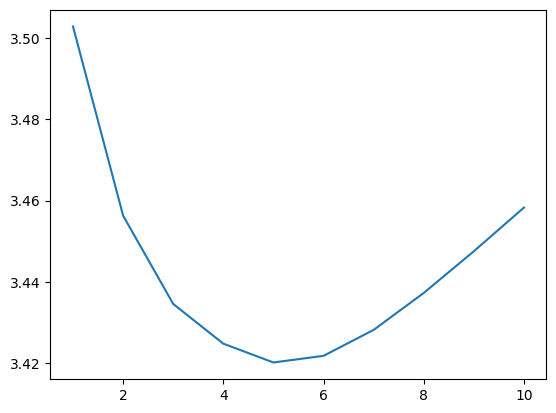

In [ ]:
errors = []
nn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n in tqdm(nn):
  algo = SVDpp(n_factors=2, n_epochs=n, random_state=42, cache_ratings=True)
  algo.fit(trainset)
  pred = algo.test(testset)
  error = accuracy.rmse(pred)
  errors.append(error)

plt.plot(nn, errors)

In [ ]:
# define a cross-validation iterator
param_grid = {'n_factors':[2],
              'n_epochs':[4],
              'random_state':[42],
              'cache_ratings':[True]}

kf = KFold(n_splits=5)
gs = GridSearchCV(SVDpp, param_grid=param_grid, measures=['rmse'], cv=5, n_jobs=1)

gs.fit(data)

In [ ]:
# best RMSE score
print("best RMSE score :",gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print("best RMSE parameters :",gs.best_params["rmse"])

# save reports
# pd.DataFrame.from_dict(gs.cv_results).to_csv(PATH+'/GS_report(SVDpp).csv', encoding='UTF-8', index=False)
# with open(PATH+'best_param(SVDpp).json', 'w') as f:
#     json.dump(gs.best_params["rmse"], f)

best RMSE score : 3.4300681665660813
best RMSE parameters : {'n_factors': 2, 'n_epochs': 4, 'random_state': 42, 'cache_ratings': True}


In [ ]:
algo = gs.best_estimator["rmse"]
algo.fit(data.build_full_trainset())

# save model
with open(PATH+'SVDpp_with_GS_model.pickle', 'wb') as f:
    pickle.dump(algo, f, pickle.HIGHEST_PROTOCOL)

# load model
# with open(PATH+'SVDpp_with_GS_model.pickle', 'rb') as f:
#     algo = pickle.load(f)

## 모델 학습 및 추론

In [ ]:
test_df = pd.read_csv(PATH+'/test.csv', encoding='UTF-8')[['ID', 'User-ID','Book-ID']]
test_df.head(3)

,ID,User-ID,Book-ID
0,TEST_000000,USER_00008,BOOK_047966
1,TEST_000001,USER_00008,BOOK_119494
2,TEST_000002,USER_00008,BOOK_151775


In [ ]:
algo = SVDpp(n_factors=2, n_epochs=5, random_state=42, cache_ratings=True, verbose=True)
algo.fit(trainset)
pred = algo.test(testset)
accuracy.rmse(pred)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
RMSE: 3.4202


3.420236213655713

In [ ]:
def predict_point(dataframe:pd.DataFrame, func=algo) -> pd.DataFrame:
  num = len(dataframe)
  preds = []
  for i in range(num):
    user, item = dataframe.iloc[i,1:]
    pred = func.predict(user, item, verbose=True).est
    preds.append(pred)
  dataframe['Book-Rating'] = preds
  result = dataframe[['ID','Book-Rating']]
  return result

In [ ]:
from sklearn.model_selection import train_test_split
_, testset, dfgh, testy = train_test_split(df[['ID','User-ID','Book-ID']], df['Book-Rating'], test_size=0.2, random_state=42)

predict_point(testset, func=algo).to_csv(PATH+'/svdtest.csv', encoding='UTF-8', index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
user: USER_03419 item: BOOK_067983 r_ui = None   est = 0.41   {'was_impossible': False}
user: USER_66874 item: BOOK_226737 r_ui = None   est = 3.30   {'was_impossible': False}
user: USER_33170 item: BOOK_203022 r_ui = None   est = 1.56   {'was_impossible': False}
user: USER_82284 item: BOOK_084166 r_ui = None   est = 4.12   {'was_impossible': False}
user: USER_04053 item: BOOK_027903 r_ui = None   est = 3.86   {'was_impossible': False}
user: USER_84387 item: BOOK_114855 r_ui = None   est = 5.15   {'was_impossible': False}
user: USER_01529 item: BOOK_255408 r_ui = None   est = 2.11   {'was_impossible': False}
user: USER_24200 item: BOOK_247889 r_ui = None   est = 3.36   {'was_impossible': False}
user: USER_54776 item: BOOK_009940 r_ui = None   est = 1.59   {'was_impossible': False}
user: USER_68455 item: BOOK_079634 r_ui = None   est = 4.87   {'was_impossible': False}
user: USER_05709 item: BOOK_228069 r_ui = None   est = 2.25   {'was_impossible': Fal

In [ ]:
test_df = pd.read_csv(PATH+'/test.csv', encoding='UTF-8')[['ID', 'User-ID','Book-ID']]
answer = predict_point(test_df, func=algo)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
user: USER_88956 item: BOOK_096617 r_ui = None   est = 1.14   {'was_impossible': False}
user: USER_88956 item: BOOK_097903 r_ui = None   est = 1.17   {'was_impossible': False}
user: USER_88956 item: BOOK_098958 r_ui = None   est = 1.17   {'was_impossible': False}
user: USER_88956 item: BOOK_099680 r_ui = None   est = 0.84   {'was_impossible': False}
user: USER_88956 item: BOOK_100475 r_ui = None   est = 1.17   {'was_impossible': False}
user: USER_88956 item: BOOK_100813 r_ui = None   est = 1.53   {'was_impossible': False}
user: USER_88956 item: BOOK_102097 r_ui = None   est = 0.97   {'was_impossible': False}
user: USER_88956 item: BOOK_104581 r_ui = None   est = 1.40   {'was_impossible': False}
user: USER_88956 item: BOOK_105113 r_ui = None   est = 1.17   {'was_impossible': False}
user: USER_88956 item: BOOK_105506 r_ui = None   est = 0.72   {'was_impossible': False}
user: USER_88956 item: BOOK_105922 r_ui = None   est = 1.07   {'was_impossible': Fal

In [ ]:
answer.to_csv(PATH+'/SVDpp(2,5).csv', encoding='UTF-8', index=False)
answer.to_csv('./SVDpp(2,5).csv', encoding='UTF-8', index=False)